In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
import sklearn as sk
from sklearn.metrics import mean_squared_error
from math import sqrt
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [2]:
df = pd.read_excel('Final_clean_data.xlsx')
display(df)

,ETL_stack_sequence_C60,ETL_stack_sequence_C60 | BCP,ETL_stack_sequence_PAA | PCBM-60 | BCP,ETL_stack_sequence_PCBM-60,ETL_stack_sequence_PCBM-60 | BCP,ETL_stack_sequence_SnO2-c,ETL_stack_sequence_SnO2-np,ETL_stack_sequence_TiO2-c,ETL_stack_sequence_TiO2-c | PCBM-60,ETL_stack_sequence_TiO2-c | TiO2-mp,...,Perovskite_additives_compounds_Undoped,Perovskite_additives_compounds_nan,Cell_architecture_nip,Cell_architecture_pin,JV_scan_speed,JV_reverse_scan_PCE,JV_reverse_scan_Voc,JV_reverse_scan_Jsc,JV_reverse_scan_FF,Hystersis_index
0,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,125.0,0.00042,0.010,0.700,0.060,1.000000
1,0,0,0,0,0,0,0,0,0,1,...,0,1,1,0,50.0,0.03010,0.542,0.165,0.336,0.239203
2,0,0,0,0,0,0,0,0,0,1,...,0,1,1,0,20.0,0.06000,0.870,0.380,0.180,0.166667
3,0,0,0,0,0,0,0,0,0,1,...,0,1,1,0,20.0,0.07000,0.880,0.480,0.170,0.142857
4,0,0,0,0,0,0,0,0,0,1,...,0,1,1,0,20.0,0.09000,0.890,0.620,0.160,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224,0,1,0,0,0,0,0,0,0,0,...,1,0,0,1,20.0,20.83000,1.138,23.670,0.770,0.017763
1225,0,0,1,0,0,0,0,0,0,0,...,1,0,0,1,40.0,21.09000,1.088,23.997,0.807,0.020863
1226,0,0,1,0,0,0,0,0,0,0,...,1,0,0,1,40.0,21.02000,1.074,24.317,0.805,0.009515
1227,0,0,0,0,0,1,0,0,0,0,...,0,1,1,0,10.0,21.54000,1.186,23.250,0.782,0.030641


In [3]:
X,y = df.drop('Hystersis_index', axis=1), df['Hystersis_index']

from sklearn.model_selection import train_test_split
# Split the data into training and temporary sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

# Split the temporary set into validation and test sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

In [81]:
def build_model(hp):
    model = tf.keras.Sequential()
    hp_activation = hp.Choice('activation', values=['elu', 'tanh','relu'])
    hp_layer_1 = hp.Int('layer_1', min_value=32, max_value=64, step=1)
    hp_layer_2 = hp.Int('layer_2', min_value=32, max_value=64, step=1)
    hp_layer_3 = hp.Int('layer_3', min_value=32, max_value=64, step=1)
    model.add(tf.keras.layers.Dense(units=hp_layer_1, activation=hp_activation))
              
    model.add(tf.keras.layers.Dense(units=hp_layer_2, activation=hp_activation))
              
    model.add(tf.keras.layers.Dense(units=hp_layer_3, activation=hp_activation))# Adding dropout layer
    model.add(layers.Dense(1,activation='linear'))  # Output layer for regression

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])),
                  loss='mean_absolute_error',
                  metrics=['mean_absolute_error'])
    return model

In [92]:
from keras_tuner.tuners import RandomSearch, BayesianOptimization, Hyperband

tuner = BayesianOptimization(
build_model,
    objective='val_mean_absolute_error',  # Objective to minimize
    max_trials=20,
    directory='my_tuner_dir_forNN_with3layers8',
    project_name='my_regression_model11'
)


In [93]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [94]:
tuner.search(X_temp, y_temp, epochs=100, validation_split=0.2, callbacks=[stop_early])

Trial 20 Complete [00h 00m 04s]
val_mean_absolute_error: 0.11327996850013733

Best val_mean_absolute_error So Far: 0.09921800345182419
Total elapsed time: 00h 01m 31s


In [99]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
display(best_hps)

In [96]:
model = tuner.hypermodel.build(best_hps)

8/8 [==============================] - 0s 2ms/step
0.37657995187895854


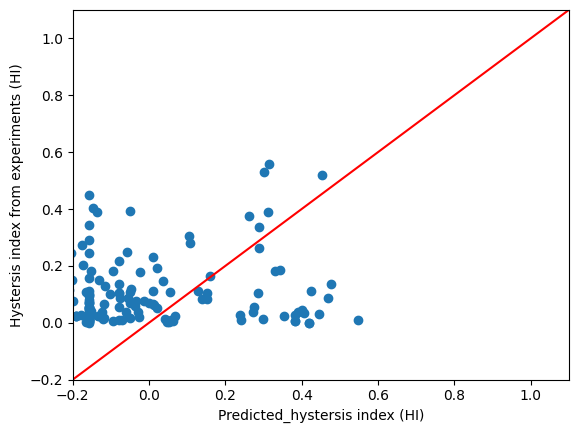

In [97]:
ypred_NN = model.predict(X_test)
plt.scatter(ypred_NN,y_test)
print(sqrt(mean_squared_error(ypred_NN,y_test)))
lim1T,lim2T = -0.2,1.1
xlimT,ylimT = [lim1T,lim2T], [lim1T,lim2T]
plt.xlim(lim1T,lim2T)
plt.ylim(lim1T,lim2T)
plt.plot(xlimT,ylimT, color = 'r')
plt.xlabel('Predicted_hystersis index (HI)')
plt.ylabel('Hystersis index from experiments (HI)')
plt.show()

39/39 [==============================] - 0s 1ms/step
0.37657995187895854


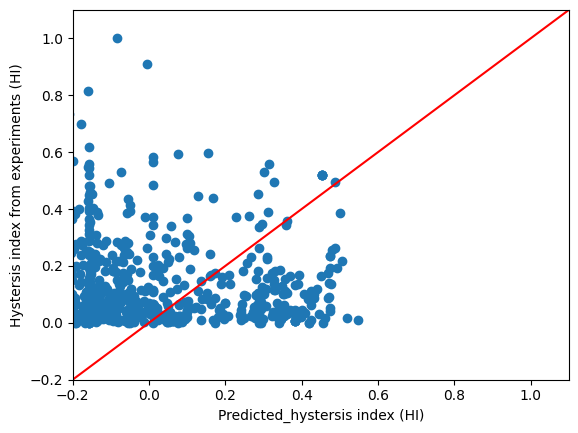

In [98]:
ypred_full_NN = model.predict(X)
plt.scatter(ypred_full_NN,y)
print(sqrt(mean_squared_error(ypred_NN,y_test)))
lim1T,lim2T = -0.2,1.1
xlimT,ylimT = [lim1T,lim2T], [lim1T,lim2T]
plt.xlim(lim1T,lim2T)
plt.ylim(lim1T,lim2T)
plt.plot(xlimT,ylimT, color = 'r')
plt.xlabel('Predicted_hystersis index (HI)')
plt.ylabel('Hystersis index from experiments (HI)')
plt.show()

Plotting HI vs various parameters

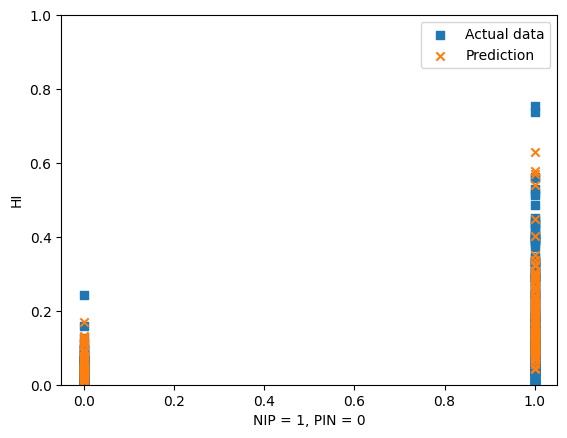

In [47]:
plt.scatter(X_test['Cell_architecture_nip'],y_test, label = 'Actual data', marker= 's')
plt.scatter(X_test['Cell_architecture_nip'],y_pred, label = 'Prediction', marker='x')
plt.ylim(0,1)
plt.legend()
plt.xlabel('NIP = 1, PIN = 0')
plt.ylabel('HI')
plt.show()

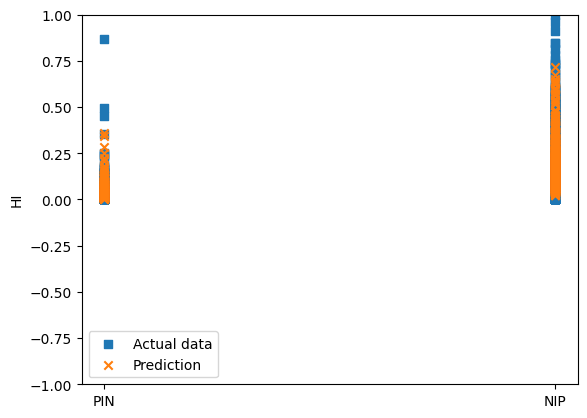

In [48]:

# Assuming 'labels' contains the labels for 0 and 1
labels = ['PIN', 'NIP']

# Your existing code for scatter plot
plt.scatter(X['Cell_architecture_nip'], y, label='Actual data', marker='s')
plt.scatter(X['Cell_architecture_nip'], y_fullpred, label='Prediction', marker='x')

# Set y-axis limits
plt.ylim(-1, 1)

# Set x-axis tick labels
plt.xticks([0, 1], labels)

# Add labels, legend, and show plot
plt.legend()
plt.ylabel('HI')
plt.show()

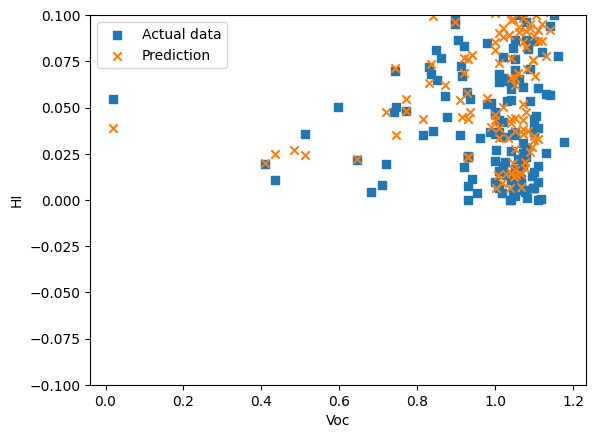

In [49]:
plt.scatter(X_test['JV_reverse_scan_Voc'],y_test, label = 'Actual data', marker= 's')
plt.scatter(X_test['JV_reverse_scan_Voc'],y_pred, label = 'Prediction', marker='x')
plt.ylim(-0.1,0.1)
plt.xlabel('Voc')
plt.ylabel('HI')
plt.legend()
plt.show()

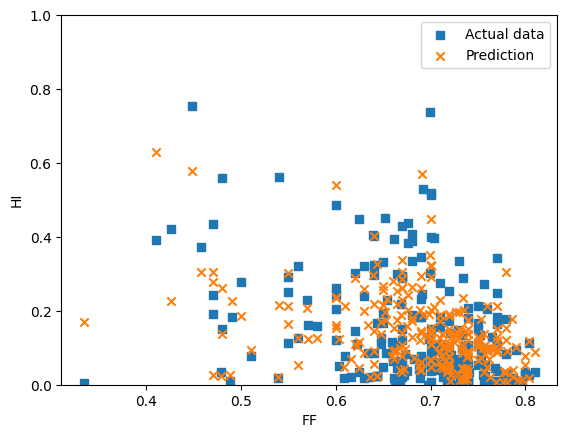

In [50]:
plt.scatter(X_test['JV_reverse_scan_FF'],y_test, label ='Actual data', marker='s')
plt.scatter(X_test['JV_reverse_scan_FF'], y_pred, label='Prediction', marker='x')
plt.ylim(0,1)
plt.xlabel('FF')
plt.ylabel('HI')
plt.legend()
plt.show()

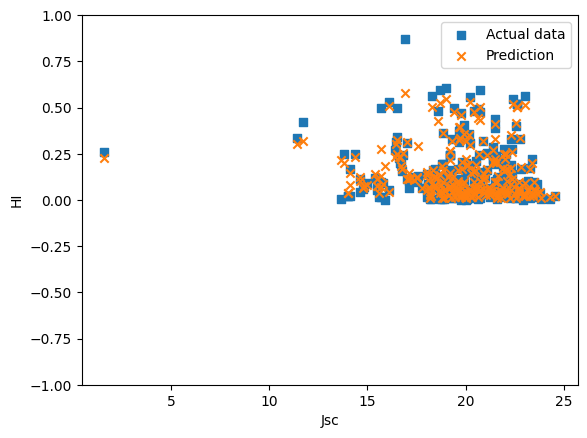

In [15]:
plt.scatter(X_test['JV_reverse_scan_Jsc'],y_test, label ='Actual data', marker='s')
plt.scatter(X_test['JV_reverse_scan_Jsc'], y_pred, label='Prediction', marker='x')
plt.ylim(-1,1)
plt.xlabel('Jsc')
plt.ylabel('HI')
plt.legend()
plt.show()

In [106]:
import tensorflow as tf
from tensorflow import keras
from keras_tuner import HyperModel
from keras_tuner.tuners import BayesianOptimization

# Define the HyperModel class
class RegressionHyperModel(HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        
        # Add input layer
        model.add(keras.layers.Input(shape=(X_train.shape[1],)))
        
        # Add hidden layers
        for i in range(hp.Int('num_layers', 1, 3)):
            model.add(keras.layers.Dense(
                units=hp.Int('units_' + str(i), min_value=1, max_value=64, step=1),
                activation='relu'))
            model.add(keras.layers.Dropout(
                rate=hp.Float('dropout_' + str(i), min_value=0.0, max_value=0.5, step=0.1)))
        
        # Add output layer
        model.add(keras.layers.Dense(1))
        
        # Compile the model
        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
            loss='mean_squared_error',
            metrics=['mean_absolute_error'])
        
        return model

# Instantiate the HyperModel
hypermodel = RegressionHyperModel()

# Choose the Tuning Strategy
tuner = BayesianOptimization(
    hypermodel,
    objective='val_mean_absolute_error',
    max_trials=20,  # Number of different hyperparameter combinations to try
    executions_per_trial=2,  # Number of times to evaluate each combination
    directory='my_dir1',
    project_name='regression_tuning'
)

# Define callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Conduct the hyperparameter search
tuner.search(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model
model = tuner.hypermodel.build(best_hps)

# Train the best model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate the model
evaluation = model.evaluate(X_test, y_test)
print(f"Test Loss: {evaluation[0]}, Test MAE: {evaluation[1]}")

# Print the best hyperparameters
print(f"The best hyperparameters are: {best_hps.values}")


Trial 20 Complete [00h 00m 25s]
val_mean_absolute_error: 0.34397628903388977

Best val_mean_absolute_error So Far: 0.10807459428906441
Total elapsed time: 00h 03m 12s
Epoch 1/100
24/24 [==============================] - 1s 8ms/step - loss: 19056094.0000 - mean_absolute_error: 483.3109 - val_loss: 0.0339 - val_mean_absolute_error: 0.1117
Epoch 2/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0346 - mean_absolute_error: 0.1194 - val_loss: 0.0326 - val_mean_absolute_error: 0.1101
Epoch 3/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0340 - mean_absolute_error: 0.1183 - val_loss: 0.0325 - val_mean_absolute_error: 0.1100
Epoch 4/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0339 - mean_absolute_error: 0.1182 - val_loss: 0.0325 - val_mean_absolute_error: 0.1100
Epoch 5/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0339 - mean_absolute_error: 0.1182 - val_loss: 0.0325 - val_mean_absolute_error: 0.1100
Epoch 6/1

In [107]:
prediction_test = model.predict(X_test)

8/8 [==============================] - 0s 2ms/step


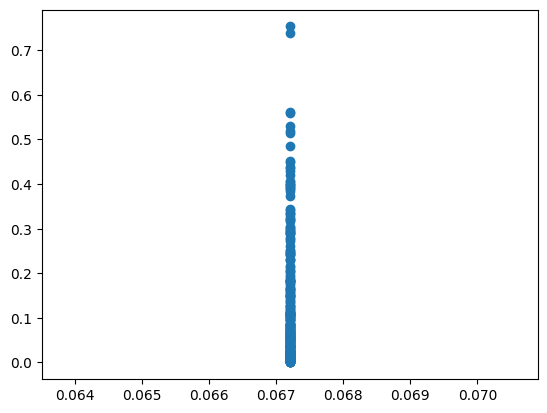

In [108]:
plt.scatter(prediction_test,y_test)